In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Resizing, Rescaling, InputLayer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

2024-09-10 11:13:46.857204: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 11:13:48.100613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Thiết lập để chỉ sử dụng bộ nhớ GPU cần thiết
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Success")
    except RuntimeError as e:
        print(e)  # Xử lý lỗi nếu có

Success


2024-09-10 11:13:52.291973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 11:13:52.483196: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 11:13:52.483514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Task Understand

## Introduce

Theo tổ chức y tế thế giới WHO, ước lượng (estimate) có khoảng 409000 người chết vì sốt rét (malaria) vào năm 2019

Trong bài này ta sẽ build 1 machine learning model dựa trên covolutional neural networks để chuẩn đoán (diagnose) người mắc bệnh sốt rét dựa trên thông tin về tế bào máu của họ

Đây là bài toán dạng phân loại input cell (là hình ảnh của tế bào máu) có chứa virut sốt rét không (hay bị ký sinh malaria paratise)

## How to get input

Cách lấy dữ liệu: Bác sĩ hành nghề sẽ đam thủng tay của người xét nghiệm và lấy máu của họ (thường lấy ở ngón tay thứ 3 hoặc 4)

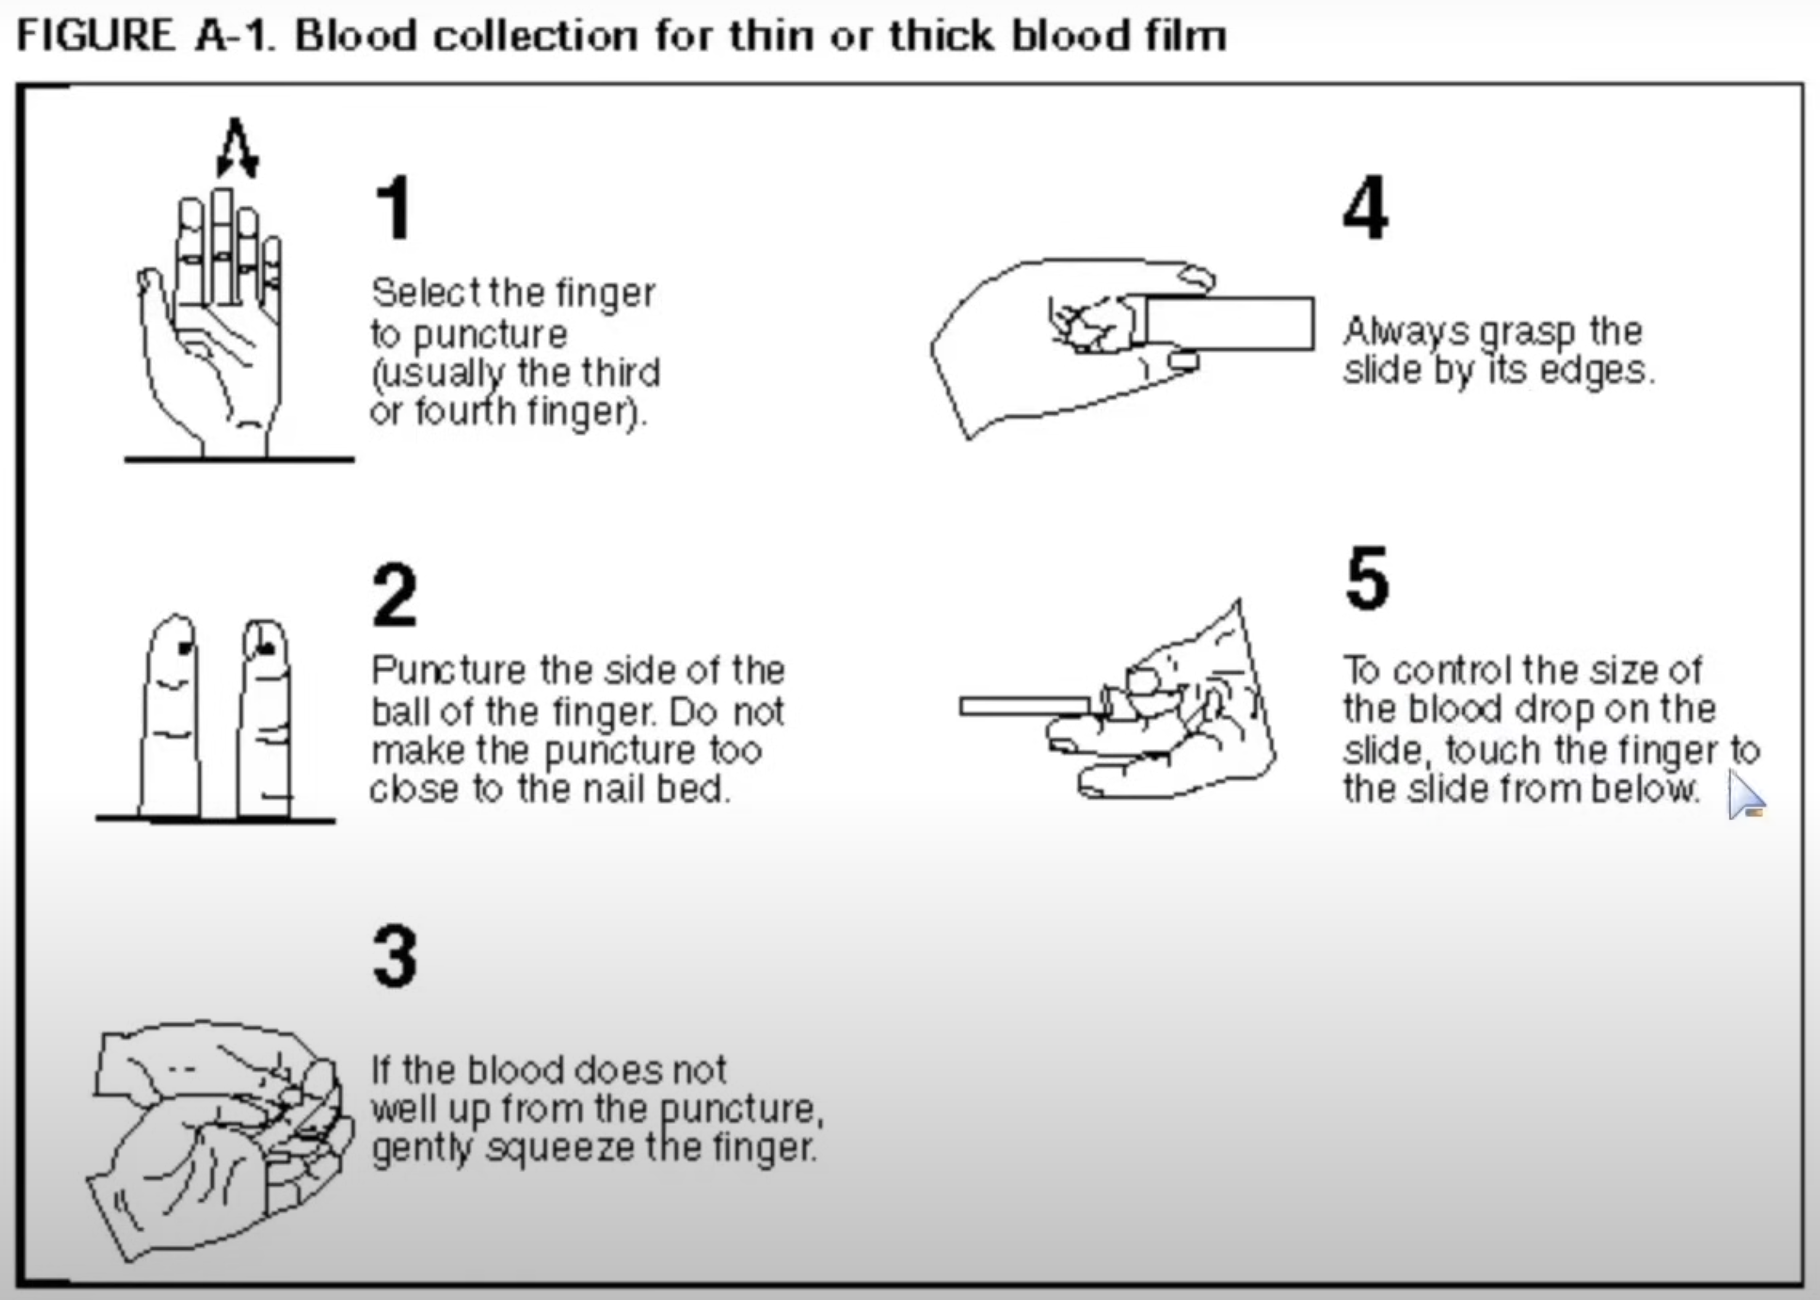

Có 2 loại máu mà ta có thể thu được là thin smear và thick smear. Dữ liệu mà ta thu được trong bài này là thin smear. Ở hình cuối bên góc phải, ta thấy được các tế bào máu của người xét nghiệm. Dataset của ta chính là hình ảnh của các tế bào máu này và ta cần build 1 model để phân loại tế bào nào là parasitized (bị ký sinh) hay uninfected (không bị ký sinh) bởi virut malaria => Bài toán phân loại nhị phân

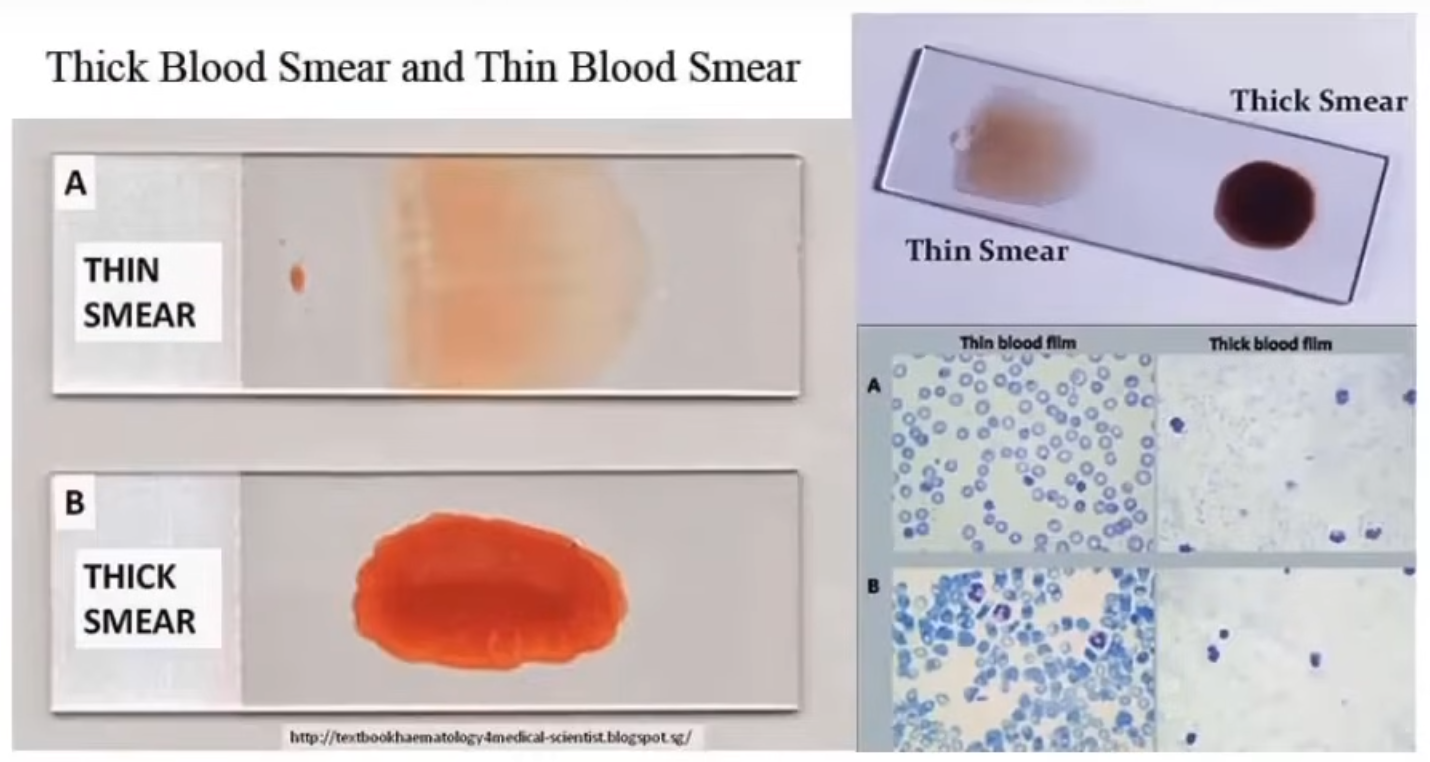

## Dataset

Dataset được lấy từ các dataset mẫu của tensorflow website, kích thước image là (86 * 82)

Là hệ màu rgb => ma trận ảnh có 3 chiều (HWC- Hight, Width, Channel=3), các giá trị mỗi phần tử nằm trong khoảng 0 -255

Nguồn: https://www.tensorflow.org/datasets/catalog/malaria

Muốn train 1 model tốt phải hiểu dataset, nhấn "explore on papers with code" để vào giao diện hiểu vấn đề

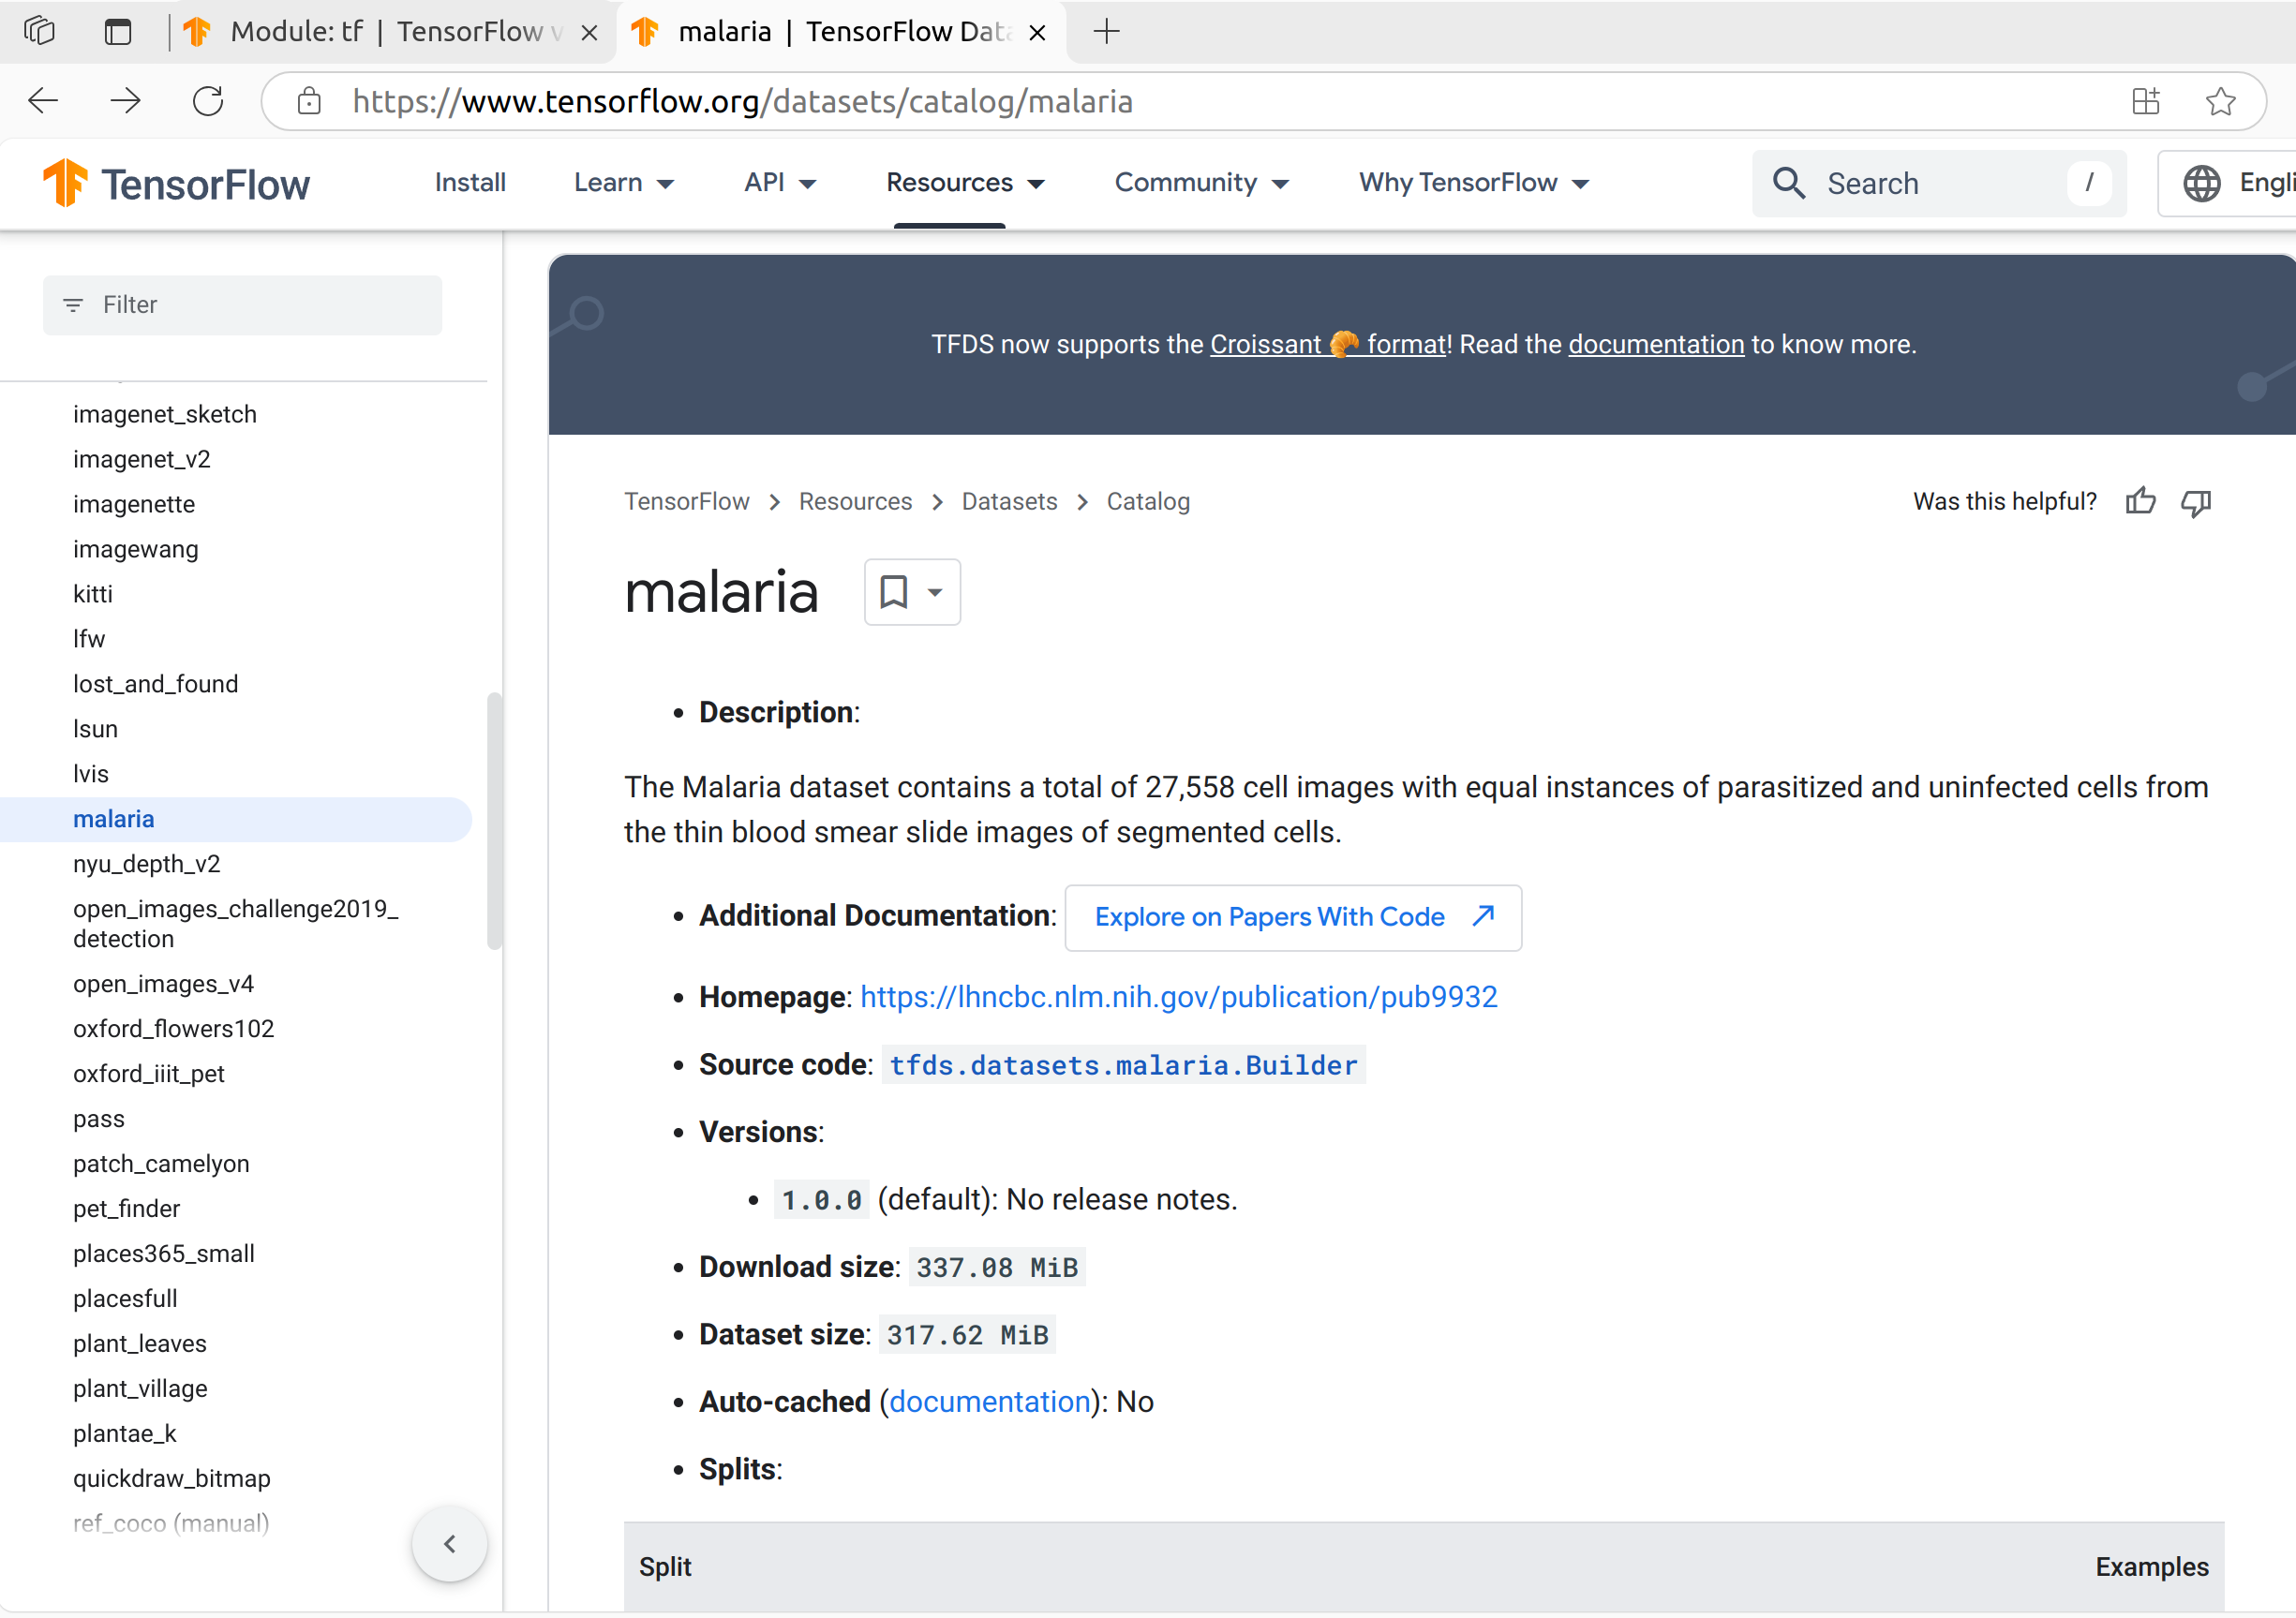

dataset có 27,558 ảnh tế bào máu, trong đó có 50% ảnh tế bào chứa virut malaria và 50% ảnh tế bào không nhiễm virut sốt rét

xem chi tiết hơn tại 6:38:38 đến 6:38:50

# Data Preparation

## Load Dataset

Sử dụng phương thức loader của thư viện tensorflow_datasets để load dataset từ tensorflow

Kết quả trả về là 1 dataset ở dạng tf.data.Dataset và metadata của nó

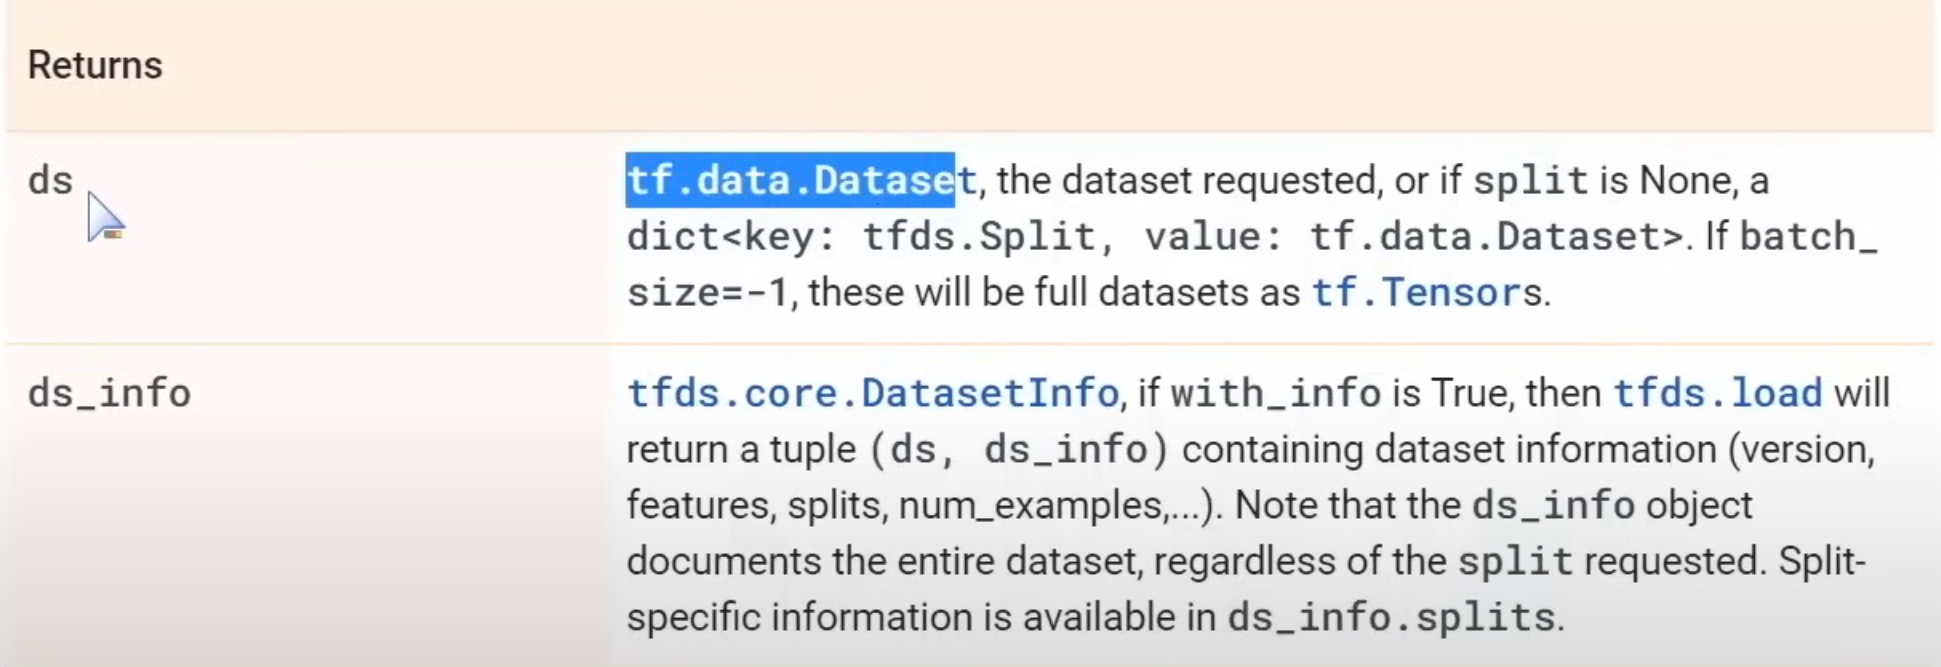

Chi tiết cách sử dụng phương thức load xem tại: https://www.tensorflow.org/datasets/api_docs/python/tfds/load

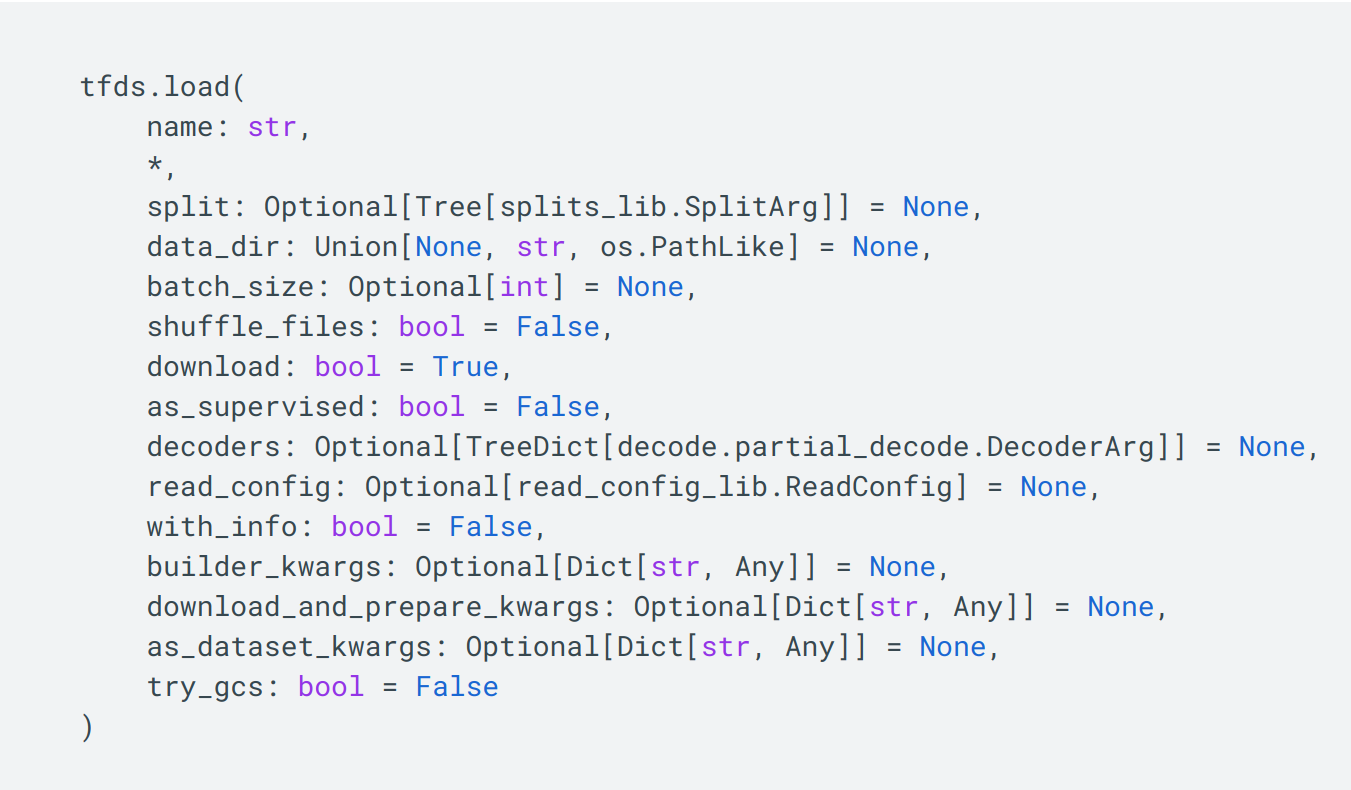

In [7]:
tfds.core.utils.gcs_utils._is_gcs_disabled = True
os.environ['NO_GCE_CHECK'] = 'true'
# Đọc các giá trị mặc định ở modul tfds.load sẽ thấy with_info = false nên ta không thể lấy dataset_info
# as_supervised=True: chỉ định rằng bạn muốn tải dữ liệu dưới dạng cặp (dữ liệu, nhãn), trong đó nhãn là thông tin về lớp của mỗi mẫu.
# shuffle_files=True: Trộn dataset theo 1 thứ tự bất kỳ để tránh sai sót dựa trên cách thu thập dữ liệu
# split=['train']: Tệp dataset này chỉ chia có thành tệp 'train' đọc document phần spilit của malaria dataset
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [8]:
# TensorSpec(shape=(None, None, 3), dtype=tf.unit8, name=None): Là 1 tensor đại diện cho các image 
# TensorSpec(shape=(), dtype=tf.int64, name=None): Là 1 tensor đại diện cho label của các image
# dataset là 1 list (image, label)
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [9]:
# Cách 1: Dùng vòng lặp để đếm
num_images = sum(1 for _ in dataset[0])
print("Số lượng hình ảnh:", num_images)

# Cách 2: Sử dụng reduce
num_images = dataset[0].reduce(0, lambda x, _: x + 1).numpy()
print("Số lượng hình ảnh:", num_images)

2024-09-10 11:14:15.026038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Số lượng hình ảnh: 27558
Số lượng hình ảnh: 27558


In [10]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/home/vohoang/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood 

## Preparation dataset

In [11]:
# 1: Chia dataset thành các tập train, val, test
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [12]:
# Các hàm thường dùng với tf.data.Dataset là take(n) - lấy n phần tử đầu tiên của dataset, skip(n) - skip n phần tử đầu tiên của dataset, as_numpy_iterator() - print 1 phần tử của dataset
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    # Lấy các phần tử đầi tiên
    train = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    
    # skip cac phan tu da dung lam train set
    val_test = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val = val_test.take(int(VAL_RATIO * DATASET_SIZE))
    
    test = val_test.skip(int(VAL_RATIO * DATASET_SIZE))
    return train, val, test

In [13]:
train, val, test = splits(dataset=dataset[0], TRAIN_RATIO=TRAIN_RATIO, VAL_RATIO=VAL_RATIO, TEST_RATIO=TEST_RATIO)
print(list(train.take(1).as_numpy_iterator()))
# Số 1 cuối cùng là giá trị của label

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


2024-09-10 11:14:17.480278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
# 2: Covert ảnh ra kích thước (224 * 224 * 3)
# Lý do resize về 224: các mạng neutron hiện đại được giới thiệu trong các cuộc thi image net hoạt động với ảnh có kích thước 224 * 224 * 3 (là dataset của cuộc thi). Thực tế ảnh có kích thước khác đều được nhưng tốt nhất khi dùng model người ta thì dùng 224 cho nó đúng
# Để ý bản phải resize, rescale ảnh với cả train, val và test set và thậm chí khi triển khai trên môi trường thực tế bạn vẫn phải làm như vậy trước khi đưa vào model. Vậy nên bạn có thể nghĩ dến tạo 1 layer để resize, rescale ảnh trong model để đỡ phải làm vậy.
# Nếu tạo 1 layer với chức năng resize, rescale thì khi fit sẽ gặp error do batch các ảnh có kích thước khác nhau. Muốn fix lỗi này phải chuyển batch về 1 => Méo ở đời chơi batch 32 chứ ko ai cơi batch 1.

Chuẩn hóa data theo phân phối chuẩn (standardization) hoặc min-max (Scaling) như bài trước đã nói

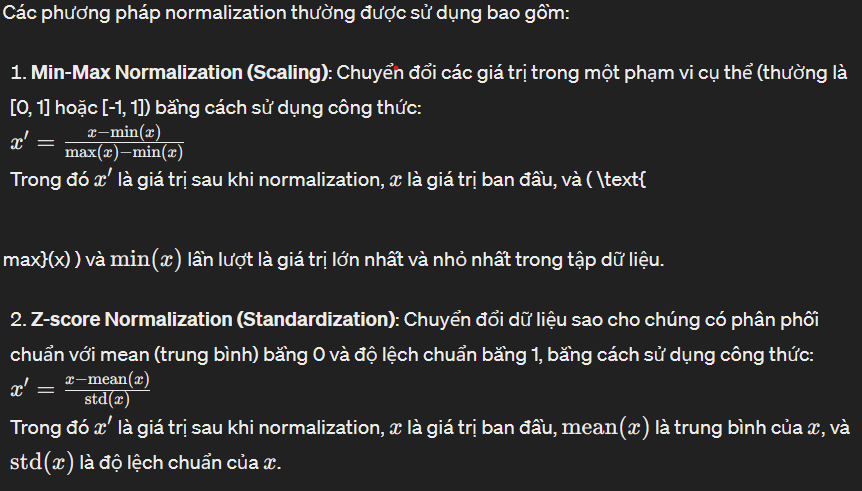

Việc chọn giữa standardize và normalize phụ thuộc vào loại data bạn đang làm việc.
- Nếu dữ liệu phân tán xung quanh 1 giá trị xác định thì dùng phân phối chuẩn
- Nếu dữ liệu luôn nắm trong phạm vị nào đó nhất định (kiểu từ 0 - 255 như bài này) hoặc luôn tồn tại những ra giá trị nằm cách xa mean của phân phối chuẩn thì dùng min-max scale

In [36]:
# tf.image.resize: https://www.tensorflow.org/api_docs/python/tf/image/resize
IMAGE_SIZE = 224
# C1: Sử dụng tf.image
def resize_rescale(image, label):
  return tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))/255.0, label

# C2: Su dung keras
# from tensorflow.keras.layers import Resizing, Rescaling
#
# resize_rescale_layers = tf.keras.Sequential([
#     Resizing(IM_ZISE, IM_SIZE),
#     Rescaling(1.0/255),
# ])
#
# Nếu sử dụng cách này thì khi map sẽ phải là val = val.map(resize_rescale_layers)

In [16]:
# def visualize(origin, augmented):
#     plt.subplot(1,2,1)
#     plt.imshow(origin[0]) # Lấy image đầu tiên của batch
    
#     plt.subplot(1,2,2)
#     plt.imshow(augmented[0]) # Lấy image đầu tiên của batch

In [17]:
# original_image, label = next(iter(train))

In [18]:
# augmented_image = tf.image.flip_left_right(original_image)
# augmented_image = tf.image.random_flip_up_down(original_image)
# augmented_image = tf.image.rot90(original_image)
# augmented_image = tf.image.adjust_brightness(original_image, delta=0.8)
# augmented_image = tf.image.random_saturation(original_image, lower=2, upper=12)
# augmented_image = tf.image.central_crop(original_image, 0.8)
# augmented_image = tf.image.flip_left_right(original_image)


In [19]:
def augment(image, label):
    image, label = resize_rescale(image, label)
    
    image = tf.image.rot90(image)
    # image = tf.image.adjust_saturation(image, saturation_factor=0.3)
    image = tf.image.flip_left_right(image)
    
    return image, label

In [20]:
# 3: Biến đổi train, val, test để phục vụ cho việc train
# train, val, test đều là dataset object trong tensorflow, cần thiết lập thêm batch_size, prefetch, reshuffer trước khi train
# Đọc lại bài cũ nếu chưa hiểu
BATCH_SIZE = 32
train = (
    train
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .map(augment) # data augmentation chỉ áp dụng với trainset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val = (
    val
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .map(resize_rescale)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test = (
    test
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .map(resize_rescale)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)
# train set đã đổi từ MapDataset thành PrefetchDataset

In [21]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Visualize dataset

2024-09-10 11:14:17.846467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


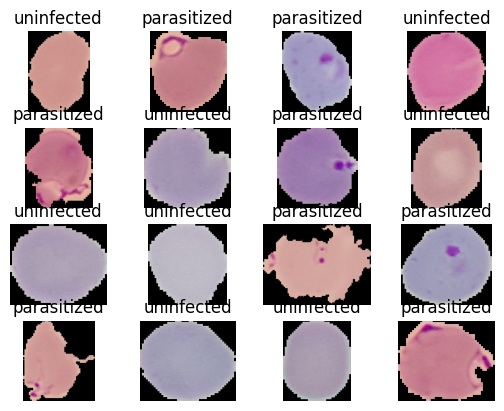

In [22]:
# Lấy 16 ảnh ngẫu nhiên từ dataset và hiển thị
for index, (image, label) in enumerate(dataset[0].take(16)):
  ax = plt.subplot(4, 4, index + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

plt.show()

# Training Model

## Build model architech

In [19]:
# Sử dụng model nổi tiếng có sẵn trong keras cho nhanh gọn
# Tải ResNet50 với trọng số đã được huấn luyện trước trên ImageNet
model = Sequential()
model.add(ResNet50(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Xem cấu trúc mô hình
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,688,065 (90.36 MB)

 Trainable params: 23,634,945 (90.16 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Compile model

### Error sanctioning

Đối với bài toán phân loại nhị phân thường sử dụng BinaryCrossEntropy làm loss function (để trừng phạt model khi dự đoán sai trong quá trình train)

Xem chi tiết tại https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

Hiểu đơn giản, Cross-Entropy loss là log loss. Được dùng để đo hiêụ suất phân loại nếu giá trị output của model nằm trong đoạn [0, 1]

### Metric

Ngoài dựa vào BinaryCrossEntropy để đánh giá model (vừa làm loss, vừa là metric để đánh giá) hay accuacy (sự chính xác), còn rất nhiều metric khác có thể  dùng để đánh giá model:

- 4 tham số bổ trợ **accuaracy**:
    - **TruePositives(TP)**: *tỷ lệ model dự đoán đúng các label = 1 (trong bài này nghĩa là model dự đoán đúng những người không bị bệnh - Uninfected)*
    - **FalsePositives(FP)**: *tỷ lệ model dự đoán sai các label = 1 (trong bài này nghĩa là model dự đoán sai những người không bị bệnh thành bị bệnh)*
    - **TrueNegatives(TN)**: *tỷ lệ model dự đoán đúng các label = 0 (trong bài này nghĩa là model dự đoán đúng những người bị bệnh - Parasited)*
    - **FalseNegatives(FN)**: *tỷ lệ model dự đoán sai các label = 0 (trong bài này nghĩa là model dự đoán sai những người bị bệnh thành không bị bệnh. Điều này cực kỳ nguy hiểm trong y tế vì thà dự đoán sai những người không bị bệnh thành bị bệnh để họ qua kiểm tra bác sĩ còn hơn. Có rất nhiều người tự tin vào AI và nghe theo phán quyết của AI mà không đi khám bác sĩ sau đó. Để model hoạt động tốt nhất, ta cần phải tối giản FN trong bài toán này về tối thiểu chứ không phải dựa vào accuaracy)*
    - 4 tham số trên có thể tổng hợp vào 1 ma trận gọi là confusion matrix

    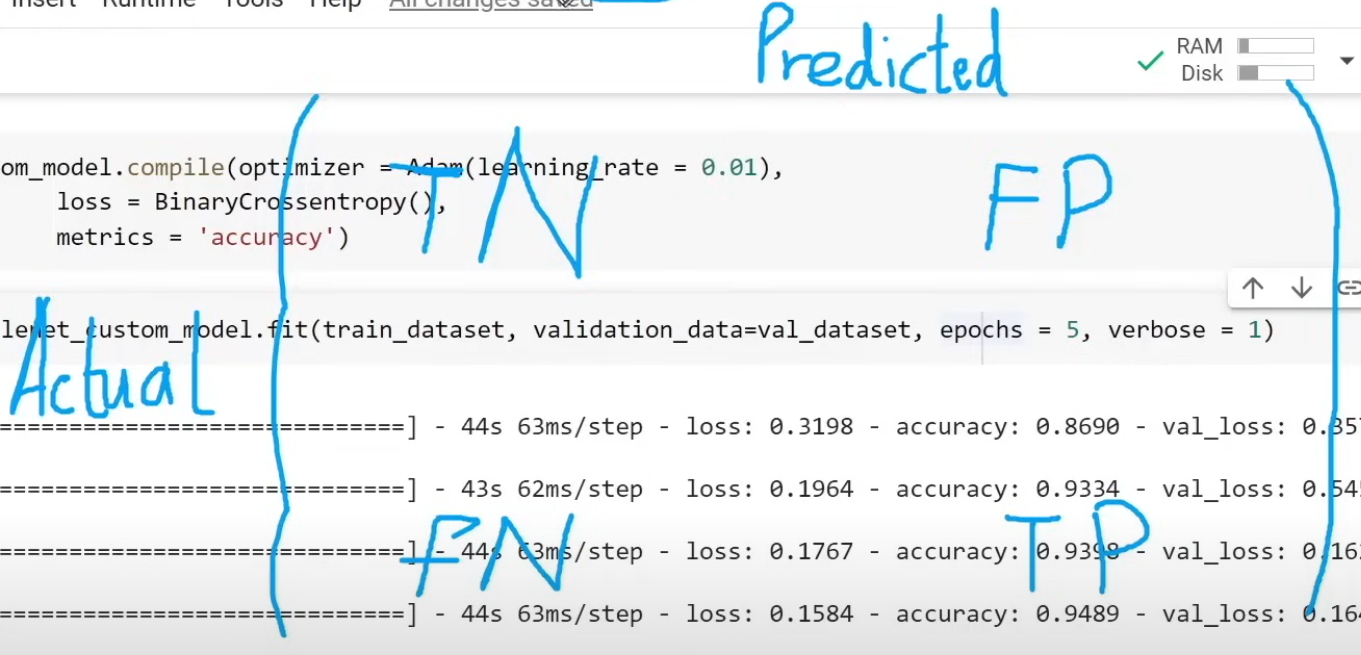
    
- Các metric khác

    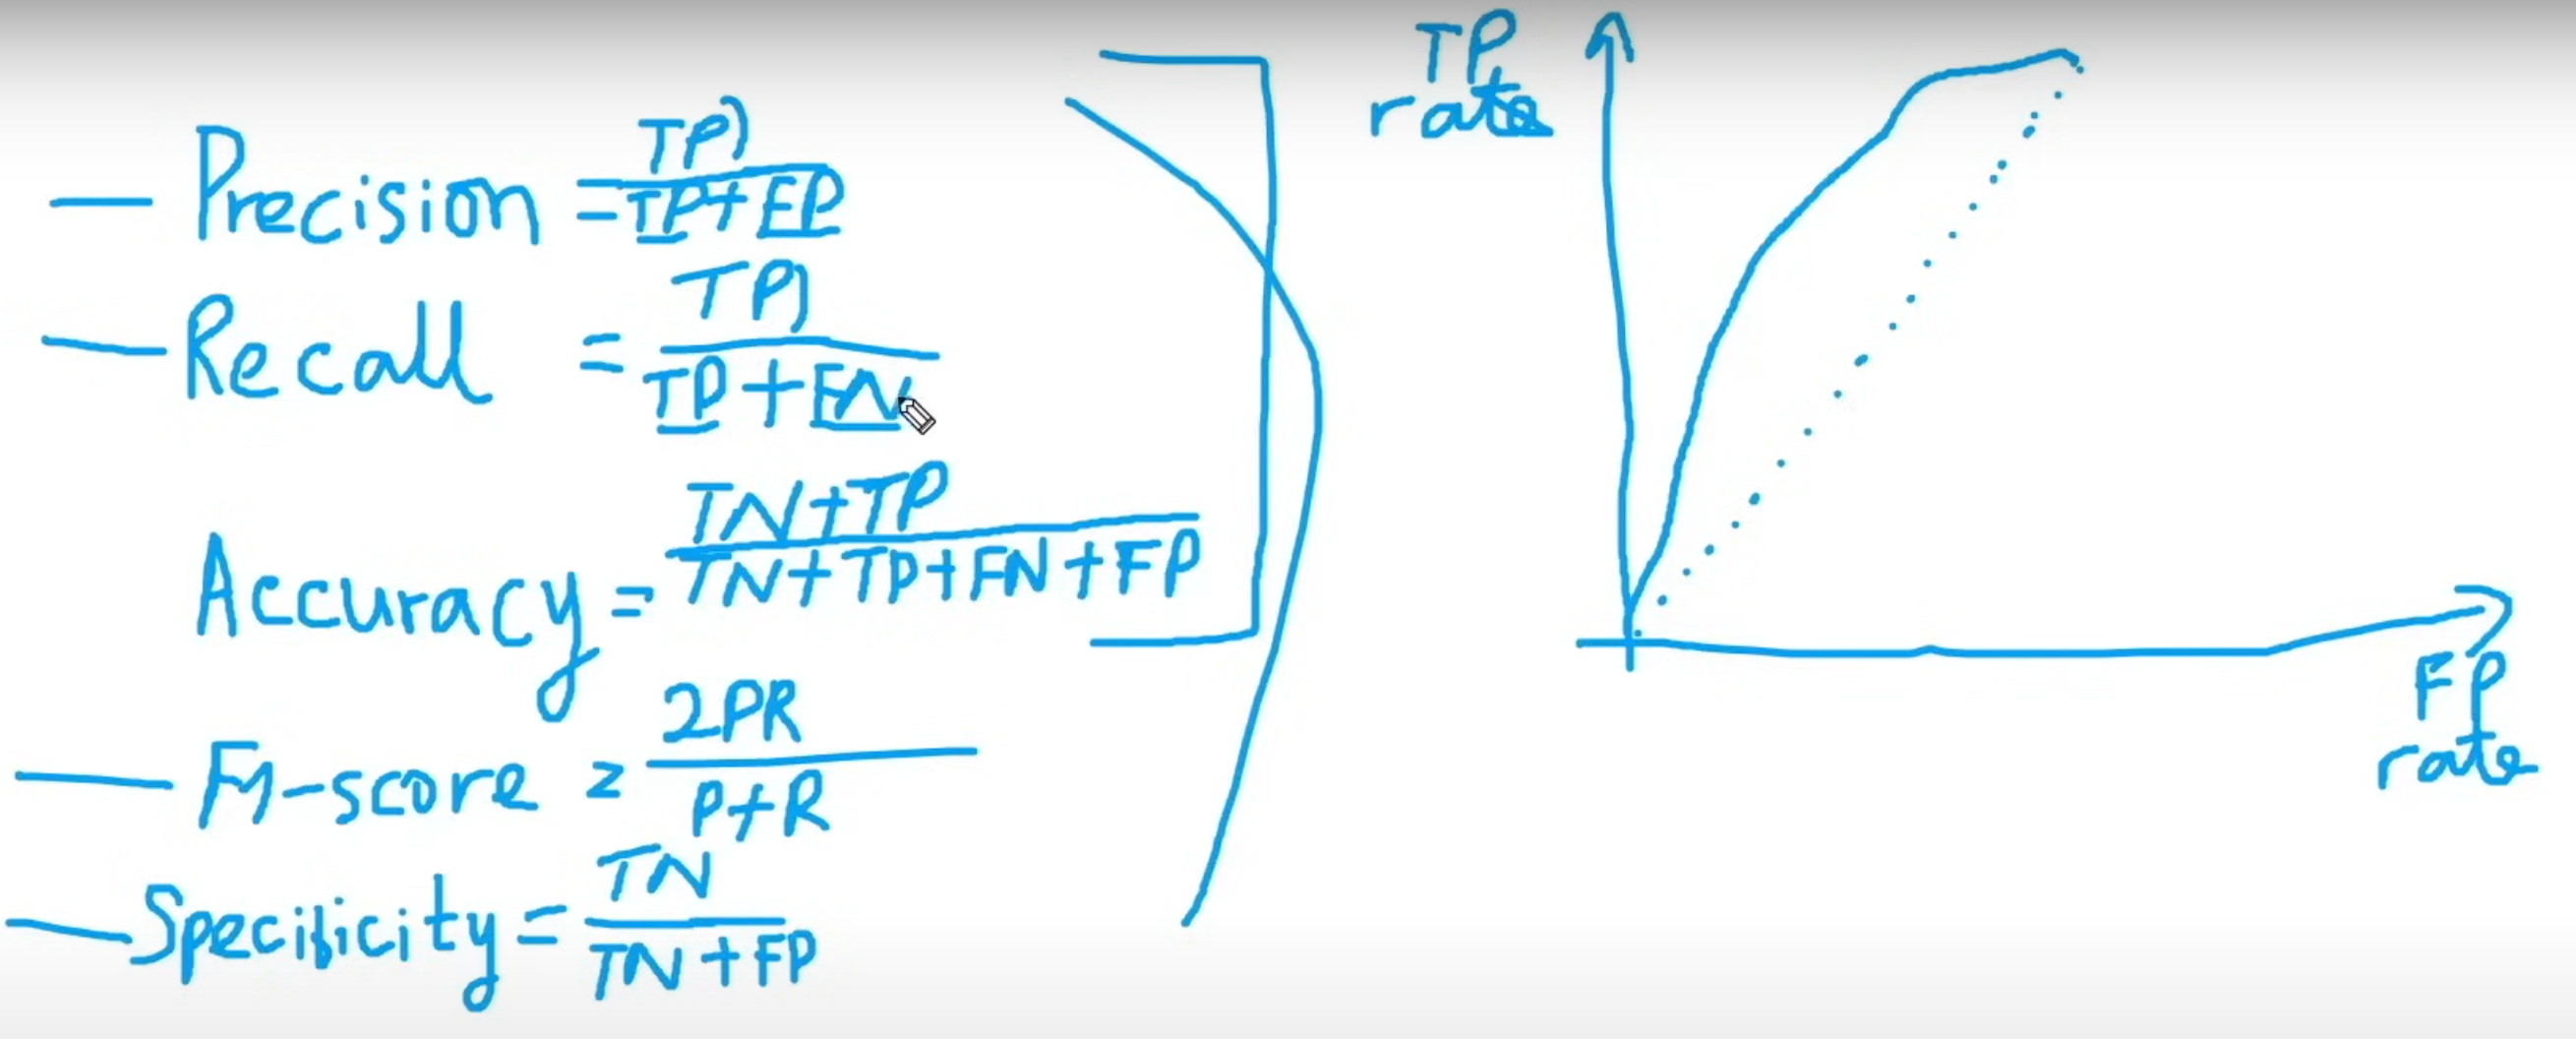

    - **Precision**: Nếu FP càng cao thì Precision càng thấp. Dự đoán tỷ lệ chính xác khi model dự đoán các mẫu thực sự dương tính
    - **Recall**: Nếu FN càng cao thì Precision càng thấp. Bài này cần FN nhỏ nhất có thể  hay recall lớn nhất có thể
    - **Specificity**: Ngược lại với Precision, dự đoán tỷ lệ chính xác khi model dự đoán các mẫu thực sự âm tính
    - **F1-score**: là chỉ số cân bằng giữa Precision và Recall. Nó cung cấp 1 con số để đánh giá cả 2 khía cạnh này cùng 1 lúc. Chỉ số này đặc biệt hữu ích khi dataset mất cân bằng, cân bằng việc giảm thiểu giữa FP và FN
- Đánh gias model dựa vào đồ thị thường dùng trong bước evaluation để tìm threshold tốt nhất 1 cách tự động(xem phần đánh giá model sau khi train)
    - **ROC (Receiver operating chracteristics)**: Model được biểu diễn bởi 1 đường cong. Mỗi điểm trên đường cong ROC tương ứng với giá trị của 1 threshold, bạn cần chọn threshold sao cho đồ thị có TP lớn nhất (TP lớn nhất nghĩa là recall lớn nhất và FN nhỏ nhất. Tuy nhiên nếu bạn phải làm việc với Precision sẽ không khôn ngoan nếu chọn TP lớn nhất vì nó dẫn đến FP lớn nhất) và FP nhỏ nhất. Thường ta sẽ chọn điểm cân bằng, là giao điểm của đường chéo và đường ROC

    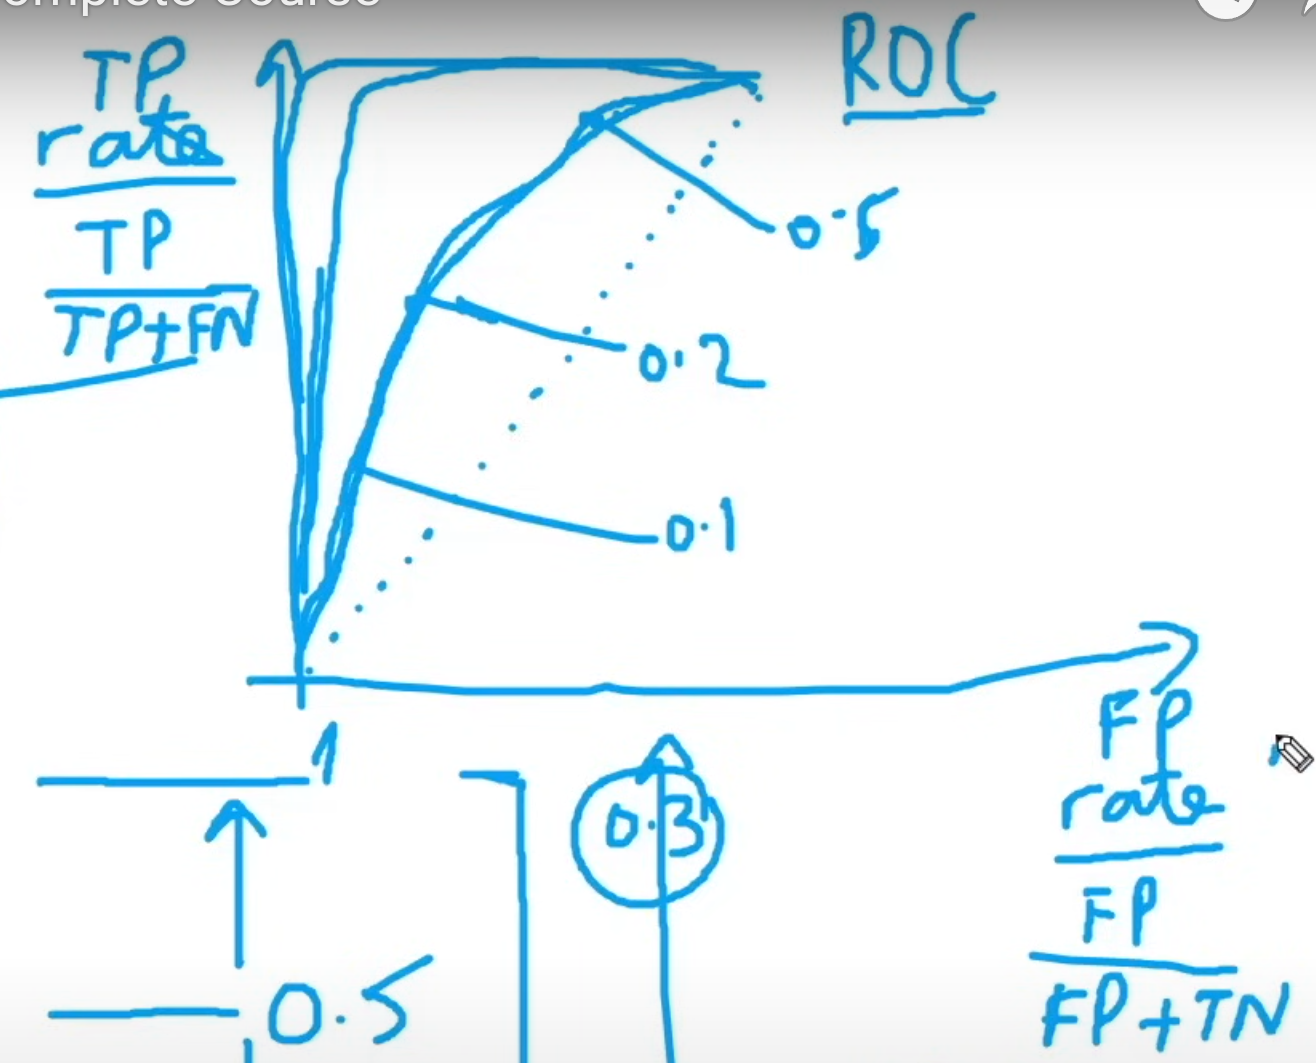

    - **AUC (Area Under the Curve)**: Là phần diện tích dưới đùng ROC, dùng để chọn model tốt nhất. Khi train model, mỗi epoch sẽ cho ra 1 model. model nào có UOC lớn nhất và gần bằng 1 thì sẽ là model tốt cho ra kết quả TP rate và FP rate tốt nhất

    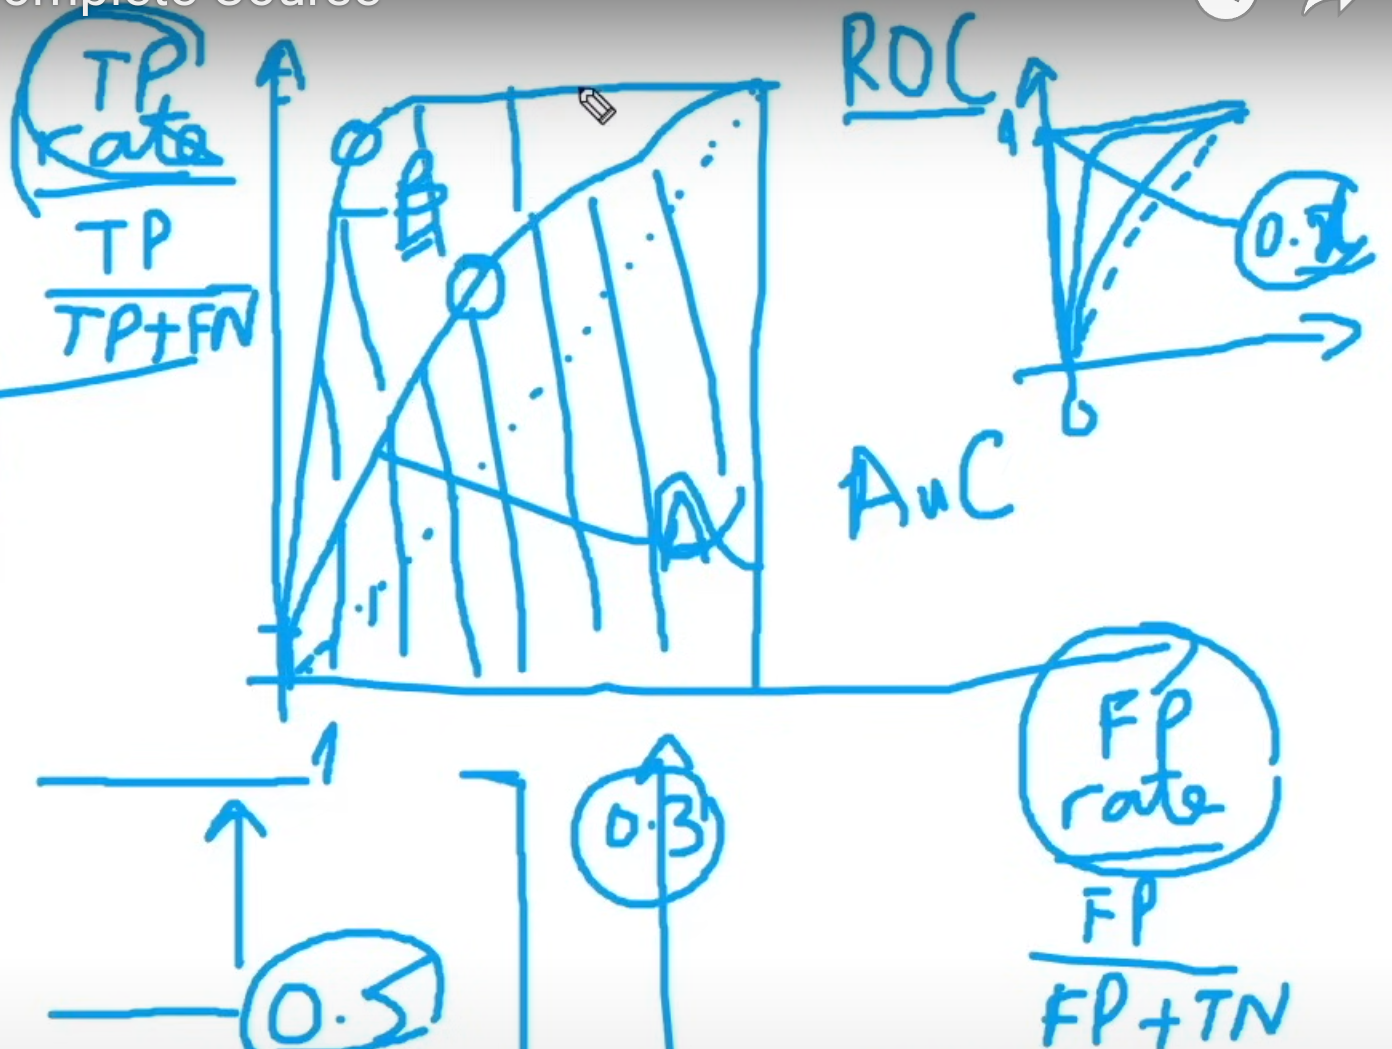

In [20]:
metrics = [
    TruePositives(name='tp'),
    FalsePositives(name='fn'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc')
]

### Callback

In [21]:
from tensorflow.keras.callbacks import Callback

class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {}".format(epoch +1, logs["loss"]))
    def on_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {}".format(batch +1, logs))

In [22]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto', 
    baseline=None,
    restore_best_weights=False
)

In [23]:
callbacks = [
    LossCallback(),
    csv_callback,
    es_callback
]

### Compile

In [24]:
model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

## Training

In [25]:
history = model.fit(train, validation_data=val, epochs=5, verbose=1, callbacks=callbacks)

Epoch 1/5


I0000 00:00:1725939586.749668    4402 service.cc:145] XLA service 0x79af80006680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725939586.749751    4402 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-09-10 10:39:47.769131: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 10:39:50.753998: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-09-10 10:39:56.853943: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-10 10:39:57.237856: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Ga


 For Batch Number 1 the model has a loss of {'accuracy': 0.5, 'auc': 0.54313725233078, 'fn': 4.0, 'fn_1': 12.0, 'loss': 0.8742097616195679, 'precision': 0.4285714328289032, 'recall': 0.20000000298023224, 'tn': 13.0, 'tp': 3.0}
  1/689 ━━━━━━━━━━━━━━━━━━━━ 9:18:30 49s/step - accuracy: 0.5000 - auc: 0.5431 - fn: 4.0000 - fn_1: 12.0000 - loss: 0.8742 - precision: 0.4286 - recall: 0.2000 - tn: 13.0000 - tp: 3.0000
 For Batch Number 2 the model has a loss of {'accuracy': 0.53125, 'auc': 0.5576735138893127, 'fn': 18.0, 'fn_1': 12.0, 'loss': 28.84314727783203, 'precision': 0.5384615659713745, 'recall': 0.6363636255264282, 'tn': 13.0, 'tp': 21.0}
  2/689 ━━━━━━━━━━━━━━━━━━━━ 4:59 436ms/step - accuracy: 0.5156 - auc: 0.5504 - fn: 11.0000 - fn_1: 12.0000 - loss: 14.8587 - precision: 0.4835 - recall: 0.4182 - tn: 13.0000 - tp: 12.0000
 For Batch Number 3 the model has a loss of {'accuracy': 0.5208333134651184, 'auc': 0.5295267105102539, 'fn': 18.0, 'fn_1': 28.0, 'loss': 24.04473876953125, 'preci

2024-09-10 10:45:15.510570: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-10 10:45:16.473082: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



 For Batch Number 689 the model has a loss of {'accuracy': 0.5229973793029785, 'auc': 0.5339133739471436, 'fn': 5972.0, 'fn_1': 4544.0, 'loss': 7.2046098709106445, 'precision': 0.5204753279685974, 'recall': 0.5878831744194031, 'tn': 5048.0, 'tp': 6482.0}
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.5223 - auc: 0.5315 - fn: 2509.6677 - fn_1: 2726.3816 - loss: 13.5707 - precision: 0.5271 - recall: 0.5290 - tn: 3001.3760 - tp: 2802.5718
 For Epoch Number 1 the model has a loss of 7.2046098709106445
689/689 ━━━━━━━━━━━━━━━━━━━━ 384s 487ms/step - accuracy: 0.5223 - auc: 0.5315 - fn: 2514.6855 - fn_1: 2729.0159 - loss: 13.5615 - precision: 0.5271 - recall: 0.5290 - tn: 3004.3420 - tp: 2807.9043 - val_accuracy: 0.4962 - val_auc: 0.5000 - val_fn: 0.0000e+00 - val_fn_1: 1388.0000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1367.0000 - val_tp: 0.0000e+00
Epoch 2/5

 For Batch Number 1 the model has a loss of {'accuracy': 0.65625, 'auc': 0.672549

In [26]:
model.save('model.keras')

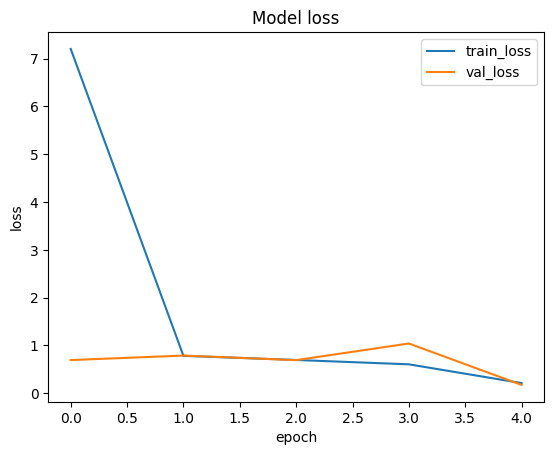

In [27]:
# Đánh giá chỉ số loss để thấy được việc train có tốt dần hay không
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

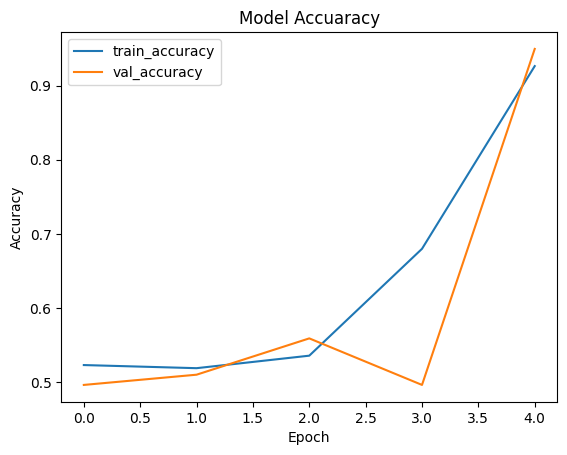

In [28]:
# Loss được dùng để trừng phạt model để model biết mình có train tốt không mà cải thiện, Metric là các thông số dễ nhìn hơn để con người có thể đánh giá model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuaracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model evaluation and testing

## Load model

In [23]:
model = load_model('model_metrics.keras')

## Evaluation

In [24]:
metrics = [
    TruePositives(name='tp'),
    FalsePositives(name='fn'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc')
]

model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=metrics)

In [25]:
model.evaluate(test)

I0000 00:00:1725941663.046988   18192 service.cc:145] XLA service 0x7d4704005930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725941663.047012   18192 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-09-10 11:14:23.199217: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 11:14:23.663440: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  13/2757 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.8705 - auc: 0.5692 - fn: 1.1538 - fn_1: 0.0000e+00 - loss: 0.9498 - precision: 0.8357 - recall: 1.0000 - tn: 1.3846 - tp: 4.4615                

I0000 00:00:1725941665.892771   18192 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2757/2757 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.8878 - auc: 0.9445 - fn: 118.2516 - fn_1: 35.8260 - loss: 0.5177 - precision: 0.8440 - recall: 0.9502 - tn: 574.7484 - tp: 650.6737


[0.5137315988540649,
 1279.0,
 233.0,
 1166.0,
 233.0,
 0.8868334889411926,
 0.8458994626998901,
 0.9418262243270874,
 0.946058452129364,
 79.0]

## Find Threshold

In [26]:
labels = []
inputs = []

for x, y in test.as_numpy_iterator():
    labels.append(y)
    inputs.append(x)
    
labels = np.array([i[0] for i in labels])
print(labels)

[0 1 0 ... 0 0 1]


2024-09-10 11:15:04.854296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
print(np.array(inputs).shape)
print(np.array(inputs)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [28]:
predicted = model.predict(np.array(inputs)[:,0,...])
print(predicted[:,0])

2024-09-10 11:15:07.776221: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1660022784 exceeds 10% of free system memory.
2024-09-10 11:15:09.740983: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1660022784 exceeds 10% of free system memory.
2024-09-10 11:15:12.889445: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 241.09MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step
[0.9997937  0.9999528  0.9999609  ... 0.42746103 0.28522843 0.9999639 ]


[[1177  211]
 [  83 1286]]


Text(0.5, 58.7222222222222, 'Predicted')

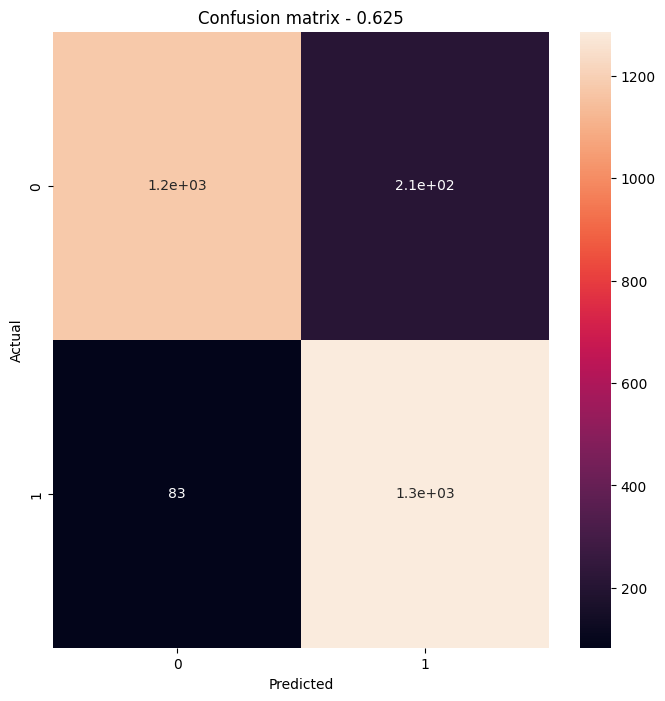

In [29]:
threshold = 0.625

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

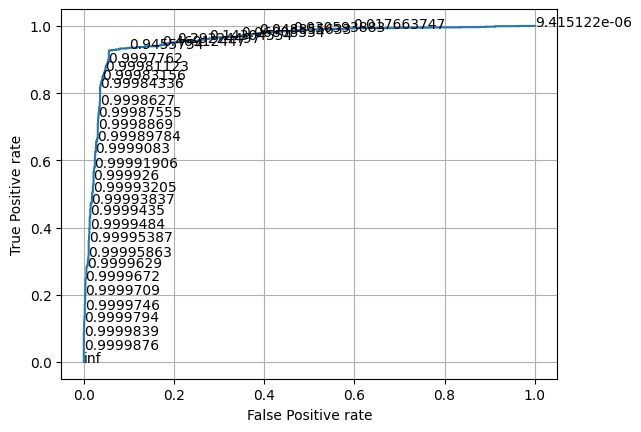

In [30]:
fp, tp, threshold = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')

plt.grid()

skip = 20

for i in range(0, len(threshold), skip):
    plt.text(fp[i], tp[i], threshold[i])
    
plt.show()
# Bài này parasite là 0, uninffect là 1 => Cần tối thiểu hóa FP => Tự nhìn đương ROC để xác định khoảng threshold cần chọn

In [31]:
def parasite_or_not(x):
    if (x < 0.5):
        return str('P')
    else:
        return str('U')

In [32]:
print(test)
print(test.take(1))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [33]:
parasite_or_not(model.predict(test.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


'P'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-09-10 11:15:37.410062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


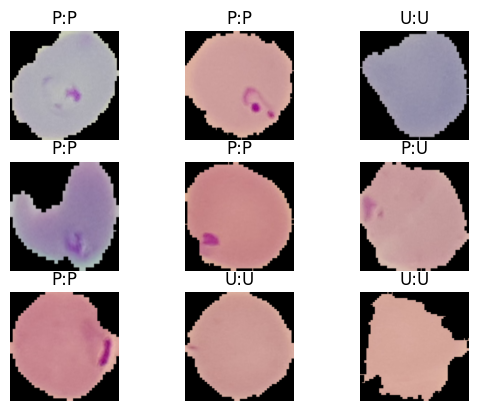

In [34]:
for index, (image, label) in enumerate(test.take(9)):
    ax = plt.subplot(3, 3, index + 1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')

plt.show()

12: